# RAFT IVF-PQ tutorial
In this tutorial you will learn to build IVF-PQ index and use it to search approximate nearest neighbors (ANN).

In [2]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# We'll need to load store some data in this tutorial
import os
import tempfile

WORK_FOLDER = os.path.join(tempfile.gettempdir(), 'raft_ivf_pq_tutorial')

if not os.path.exists(WORK_FOLDER):
   os.makedirs(WORK_FOLDER)
print("The index and data will be saved in", WORK_FOLDER)

The index and data will be saved in /tmp/raft_ivf_pq_tutorial


## Get the data
We're going to use the data from [ANN benchmarks website](https://ann-benchmarks.com),
which provides a few datasets in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/).

The list of prepared dataset can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [4]:
DATASET_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
DATASET_FILENAME = DATASET_URL.split('/')[-1]

## download the dataset
import urllib.request
dataset_path = os.path.join(WORK_FOLDER, DATASET_FILENAME)
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(DATASET_URL, dataset_path)

## Load the dataset

In [5]:
import h5py
f = h5py.File(dataset_path, "r")

metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

print(f"Loaded dataset of size {dataset.shape}; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128); metric: 'euclidean'.
Number of test queries: 10000


## Build the index
Construction of the index generally consists of two phases: training (building the clusters) and filling-in (extending the index with data).
In the first phase, a balanced hierarchical k-means algorithm clusters the training data.
In the second phase, the new data is classified and added into the appropriate clusters in the index.
Hence, a user should call `ivf_pq.build` once and then possibly `ivf_pq.extend` several times.
Though for user convenience `ivf_pq.build` by default adds the whole training set into the index.

In [6]:
# RAFT's DeviceResources controls the GPU, cuda stream, memory policies etc.
# For now, we just create a default instance.
from pylibraft.common import DeviceResources
resources = DeviceResources()

In [7]:
from pylibraft.neighbors import ivf_pq
# First, we need to initialize the build/indexing parameters.
# One of the more important parameters is the product quantisation (PQ) dim.
# Effectively, this parameter says
#      "shrink the dataset to this dimensionality to reduce the index size".
# It must be not bigger than the dataset dim,
# and it should be divisible by 32 for better GPU performance.
pq_dim = 1
while pq_dim * 2 < dataset.shape[1]:
    pq_dim = pq_dim * 2
# We'll use the ANN-benchmarks-provided metric and sensible defaults for the rest of parameters.
index_params = ivf_pq.IndexParams(n_lists=1024, metric=metric, pq_dim=pq_dim)

In [8]:
%%time
## Build the index
# This function takes a row-major either numpy or cupy (GPU) array.
# Generally, it's a bit faster with GPU inputs, but the CPU version may come in handy
# if the whole dataset cannot fit into GPU memory (or even CPU RAM -- use mmap for that).
index = ivf_pq.build(index_params, dataset, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()
index

CPU times: user 4.4 s, sys: 1.08 s, total: 5.47 s
Wall time: 5.65 s


Index(type=IVF-PQ, metric=euclidean, codebook=subspace, size=1000000, dim=128, pq_dim=64, pq_bits=8, n_lists=1024, rot_dim=128)

## Search
The search function returns the requested number `k` of (approximate) nearest neighbor in no particular order.
Besides the queries and `k`, the function can take a few more parameters to tweak the performance of the algorithm.
Again, these are passed via the struct with some sensible defaults.

In [9]:
k = 10
search_params = ivf_pq.SearchParams()

In [10]:
%%time
distances, neighbors = ivf_pq.search(search_params, index, queries, k, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()

CPU times: user 46.3 ms, sys: 1.99 ms, total: 48.3 ms
Wall time: 48.2 ms


In [11]:
## Check the quality of the prediction (recall)
def calc_recall(found_indicies, ground_truth):
    found_indicies = cp.asarray(found_indicies)
    bs, k = found_indicies.shape
    if bs != ground_truth.shape[0]:
        raise RuntimeError(
            "Batch sizes do not match {} vs {}".format(
                bs, ground_truth.shape[0])
        )
    if k > ground_truth.shape[1]:
        raise RuntimeError(
            "Not enough indicies in the ground truth ({} > {})".format(
                k, ground_truth.shape[1])
        )
    n = 0
    # Go over the batch
    for i in range(bs):
        # Note, ivf-pq does not guarantee the ordered input, hence the use of intersect1d
        n += cp.intersect1d(found_indicies[i, :k], ground_truth[i, :k]).size
    recall = n / found_indicies.size
    return recall

recall_first_try = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_first_try} with the default parameters (k = {k}).")

Got recall = 0.85242 with the default parameters (k = 10).


## Refine
Let's improve our results a little bit!
The refinement operation follows an approximate NN search.
It recomputes the exact distances for the already selected candidates and selects a subset of them thus improving the recall.

In [12]:
from pylibraft.neighbors import refine

In [13]:
%%time

candidates = ivf_pq.search(search_params, index, queries, k * 2, handle=resources)[1]
distances, neighbors = refine(dataset, queries, candidates, k, handle=resources)
resources.sync()

CPU times: user 235 ms, sys: 8.02 ms, total: 243 ms
Wall time: 247 ms


In [14]:
recall_refine2x = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_refine2x} with 2x refinement (k = {k}).")

Got recall = 0.94894 with 2x refinement (k = 10).


## Tweaking

#### Number of neighbors
Let see how QPS depens on `k`. 

38.9 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.5 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.1 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.1 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.2 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.5 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.2 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.1 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.8 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


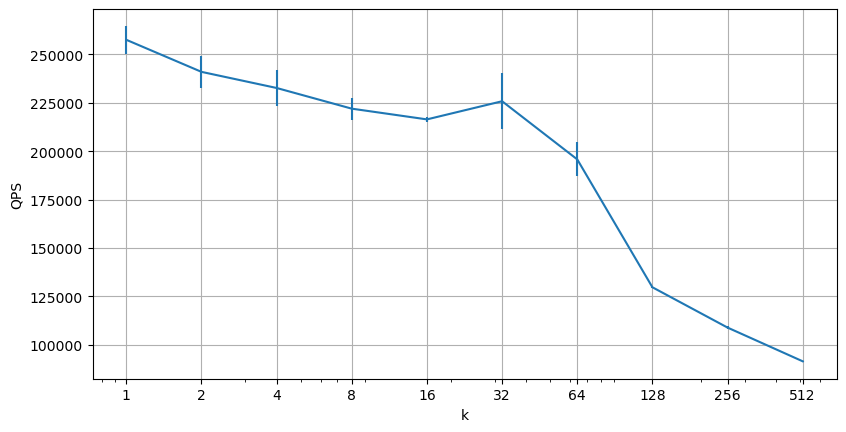

In [15]:
bench_k = np.exp2(np.arange(10)).astype(np.int32)
bench_avg = np.zeros_like(bench_k, dtype=np.float32)
bench_std = np.zeros_like(bench_k, dtype=np.float32)
for i, k in enumerate(bench_k):
    r = %timeit -o ivf_pq.search(search_params, index, queries, k, handle=resources); resources.sync()
    bench_avg[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_std[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).std()

fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
ax.errorbar(bench_k, bench_avg, bench_std)
ax.set_xscale('log')
ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('k')
ax.grid()
ax.set_ylabel('QPS');

#### Number of probes
IVF-PQ search runs in two phases; first it looks for nearest clusters,
then it searches for the neighbors in every selected cluster.

We can set how many clusters we want to inspect.
For this, `ivf_pq.SearchParams` has a parameter `n_probes`.
This is the core parameter control the QPS/recall trade-off.

In [16]:
bench_probes = np.exp2(np.arange(11)).astype(np.int32)
bench_qps = np.zeros_like(bench_probes, dtype=np.float32)
bench_recall = np.zeros_like(bench_probes, dtype=np.float32)
k = 100
for i, n_probes in enumerate(bench_probes):
    sp = ivf_pq.SearchParams(n_probes=n_probes)
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)
    

8.96 ms ± 81.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.8 ms ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.8 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30 ms ± 924 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.3 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
205 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
386 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
781 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.42 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 s ± 63.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It's clear that the search time scales almost linearly with the number of probes.
This is due to the algorithm spending most of the time in the second phase scanning through individual clusters.
Thanks to the balanced nature of the clustering k-means algorithm, the sizes of the clusters are roughly similar;
hence the linear relation `n_probes` ~ query time.

Let's draw some plots to illustrate how the number of probes affects QPS and recall.

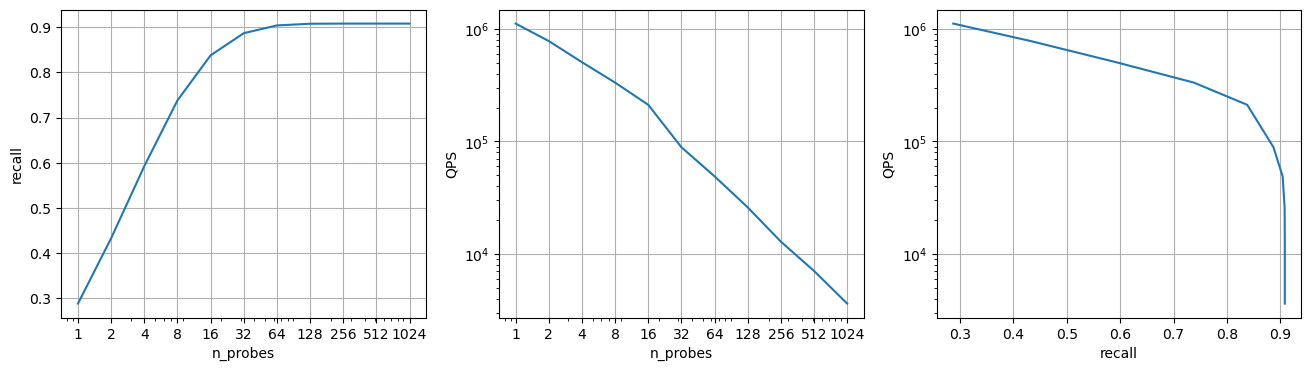

In [17]:
fig, ax = plt.subplots(1, 3, figsize=plt.figaspect(1/4))

ax[0].plot(bench_probes, bench_recall)
ax[0].set_xscale('log')
ax[0].set_xticks(bench_probes, bench_probes)
ax[0].set_xlabel('n_probes')
ax[0].set_ylabel('recall')
ax[0].grid()

ax[1].plot(bench_probes, bench_qps)
ax[1].set_xscale('log')
ax[1].set_xticks(bench_probes, bench_probes)
ax[1].set_xlabel('n_probes')
ax[1].set_ylabel('QPS')
ax[1].set_yscale('log')
ax[1].grid()

ax[2].plot(bench_recall, bench_qps)
ax[2].set_xlabel('recall')
ax[2].set_ylabel('QPS')
ax[2].set_yscale('log')
ax[2].grid();

#### Internal search types
Besides `n_probes`, `ivf_pq.SearchParams` contains couple more parameters, which affect internal workings of the algorithm.

`internal_distance_dtype` controls the representation of the distance/similarity during the search.
By default, it's `np.float32`, but you can change it to `np.float16` when appropriate to save the memory bandwidth.
This can be a good idea when the dataset type is low precision anyway (e.g. `np.uint8`),
yet it may help with 32-bit float datasets too.

`lut_dtype` is the Look-Up Table Data Type.
The specifics of the PQ algorithm is that it stores the data in the Product Quantizer (PQ) encoded format,
which needs to be decoded during the second-phase (in-cluster) search.
Thus, the algorithm constructs a lookup table for earch cluster.
This is a costly operation, and the table itself can be rather large.
By default, the individual elements in the table are stored as 32-bit floats,
but you can change this to `np.float16` or `np.uint8` to reduce the table size.

The exact size of the table is as follows:

$ \mathtt{lut\_size} = \mathtt{pq\_dim} \cdot \mathtt{sizeof(lut\_dtype) \cdot 2^{\mathtt{pq\_bits}}} $

Ideally, the lookup table should fit in the shared memory of a GPU's multiprocessor,
but it's not the case for wider datasets.
The logic of deciding whether this table should stay in the shared or the global memory of the GPU is somewhat complicated.
Yet, you can see the outcome when you gradually change `pq_dim` and observe a sudden drop in QPS after a certain threshold.
The shared-memory kernel version is typically 2-5x faster than the global-memory version.

However `pq_dim` strongly affects the recall and requires the index to be re-build on change.
This is where `lut_dtype` comes in handy: you can halve or quarter the lookup table size by changing it.
Though it does affect the recall too.

Also note, it does not make sense to set the `lut_dtype` to a more precise type than `internal_distance_dtype`,
as the former is converted to the latter internally.


In [23]:
bench_qps = np.zeros((5,), dtype=np.float32)
bench_recall = np.zeros((5,), dtype=np.float32)
k = 100
n_probes = 256
search_params_32_32 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float32)
search_params_32_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float16)
search_params_32_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.uint8)
search_params_16_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.float16)
search_params_16_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.uint8)
search_ps = [search_params_32_32, search_params_32_16, search_params_32_08, search_params_16_16, search_params_16_08]
bench_names = ['32/32', '32/16', '32/8', '16/16', '16/8']

for i, sp in enumerate(search_ps):
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)

825 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
638 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
472 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
450 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
391 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


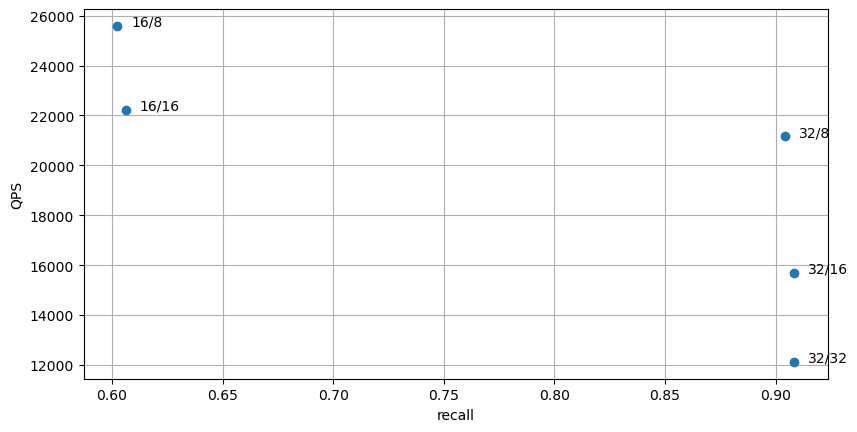

In [24]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
ax.plot(bench_recall, bench_qps, 'o')
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.grid()
for i, label in enumerate(bench_names):
    ax.annotate(
        label,
        (bench_recall[i], bench_qps[i]),
        textcoords="offset points",
        xytext=(10,0),
        ha='left') 